In [23]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import nltk
import os

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
df = pd.read_csv("Vision_Zero_Entry(2).csv", parse_dates=['REQUESTDATE'], dtype={'REQUESTTYPE': 'str', 'COMMENTS': 'str'})
df = df.dropna(subset=['COMMENTS'])
len(df)

6656

In [53]:
df.REQUESTTYPE.value_counts()

of something that is not listed here                                                                         1424
bike facilities don't exist or need improvement                                                               782
people speed                                                                                                  745
people run red lights / stop signs                                                                            663
people don't yield while turning                                                                              461
people double park their vehicles                                                                             430
it’s hard to see / low visibility                                                                             390
sidewalks/ramps don't exist or need improvement                                                               301
people don't yield while going straight                                                 

In [54]:
df['REQUESTTYPE'] = df.REQUESTTYPE.str.replace(".*</span>&nbsp;","")
df.REQUESTTYPE.value_counts()

of something that is not listed here                     1427
bike facilities don't exist or need improvement           782
people speed                                              746
people run red lights / stop signs                        663
people don't yield while turning                          461
people double park their vehicles                         430
it’s hard to see / low visibility                         392
sidewalks/ramps don't exist or need improvement           303
people don't yield while going straight                   264
people cross away from the crosswalks                     255
the roadway surface needs improvement                     222
the wait for the "Walk" signal is too long                209
there are no bike facilities or they need maintenance     128
there's not enough time to cross the street               122
it's too far / too many lanes to cross                     84
there are no sidewalks or they need maintenance            40
the road

In [55]:
df.REQUESTTYPE.replace("there are no bike facilities or they need maintenance",
                       "bike facilities don't exist or need improvement", inplace=True)
df.REQUESTTYPE.replace('people have to wait too long for the "Walk" signal',
                       'the wait for the "Walk" signal is too long', inplace=True)
df.REQUESTTYPE.replace("sidewalks/ramps don't exist or need improvement",
                       "there are no sidewalks or they need maintenance", inplace=True)
df.REQUESTTYPE.replace("the roadway surface needs maintenance",
                       "the roadway surface needs improvement", inplace=True)
df.REQUESTTYPE.replace("people have to cross too many lanes / too far",
                       "it's too far / too many lanes to cross", inplace=True)
df.REQUESTTYPE.replace("people are not given enough time to cross the street",
                       "there's not enough time to cross the street", inplace=True)
df.REQUESTTYPE.replace("it’s hard for people to see each other",
                       "it’s hard to see / low visibility", inplace=True)

In [56]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1427
bike facilities don't exist or need improvement     910
people speed                                        746
people run red lights / stop signs                  663
people don't yield while turning                    461
people double park their vehicles                   430
it’s hard to see / low visibility                   420
there are no sidewalks or they need maintenance     343
people don't yield while going straight             264
the roadway surface needs improvement               256
people cross away from the crosswalks               255
the wait for the "Walk" signal is too long          239
there's not enough time to cross the street         131
it's too far / too many lanes to cross              111
Name: REQUESTTYPE, dtype: int64

In [57]:
len(df.REQUESTTYPE.value_counts())

14

In [138]:
# drop all but relevant columns
df = df[['REQUESTTYPE', 'COMMENTS']]
# Drop simple duplicates
df = df.drop_duplicates()

In [139]:
# Drop some noise from the comments
df.COMMENTS.iloc[np.argsort(df.COMMENTS.str.len())].head(20)

5920             Test
407              Test
1156             Test
7947             test
2342          i agree
6572         Constant
1778         Too fast
6558         Non stop
4248      CONSTANTLY.
1124     Liquor store
1634     No sidewalks
7125     No bike lane
2531     no sidewalks
3616    Huge potholes
524     Poor lightung
7575    Cars speeding
1145    no bike racks
1286    No bike lanes
2636    no bike lanes
6695    LANES UNCLEAR
Name: COMMENTS, dtype: object

In [143]:
df = df[df.COMMENTS.str.len() >= 5]

In [144]:
df.COMMENTS.duplicated().sum()

9

In [151]:
df[df.COMMENTS.duplicated(keep=False)]

,REQUESTTYPE,COMMENTS
331,there are no sidewalks or they need maintenance,People park too close to the intersection and ...
333,it’s hard to see / low visibility,People park too close to the intersection and ...
4756,people don't yield while going straight,Drivers regularly barrel through this crosswal...
4757,people don't yield while turning,Drivers regularly barrel through this crosswal...
6278,people speed,There is no cross walk to connect the neighbor...
6279,people cross away from the crosswalks,There is no cross walk to connect the neighbor...
6944,people double park their vehicles,I commute by bike daily on Mass Ave from symph...
6945,bike facilities don't exist or need improvement,I commute by bike daily on Mass Ave from symph...
7098,it’s hard to see / low visibility,There's parking on both sides of this two-way ...
7099,of something that is not listed here,There's parking on both sides of this two-way ...


In [152]:
requesttype = df["REQUESTTYPE"]
comments = df["COMMENTS"]

In [153]:
text_train, text_test, y_train, y_test = train_test_split(comments, requesttype, stratify=requesttype, random_state=0)

# Baseline Model

In [154]:
vect = CountVectorizer()
X_train = vect.fit_transform(text_train)
lr = LogisticRegression(C=.1).fit(X_train, y_train)

In [155]:
X_test = vect.transform(text_test)

In [156]:
from sklearn.metrics import confusion_matrix

In [157]:
pred = lr.predict(X_test)

In [158]:
confusion_matrix(y_test, pred)

array([[161,   0,   0,  27,   0,   0,   2,   3,   2,   2,   5,   0,   2,
          0],
       [  1,   0,   1,  10,   5,   0,   2,   0,   0,   3,   0,   4,   0,
          1],
       [  3,   0,  64,  21,   0,   0,   5,   1,   1,   5,   1,   0,   2,
          0],
       [ 37,   0,   4, 210,  18,   2,  16,   6,  22,  17,   4,   1,  13,
          0],
       [  0,   0,   1,  25,  27,   1,   6,   0,   1,   2,   0,   0,   0,
          0],
       [  1,   0,   0,  18,   2,  20,   9,   1,   5,   8,   0,   0,   0,
          0],
       [ 11,   0,   2,  24,   0,   4,  49,   1,  13,   7,   0,   2,   0,
          0],
       [ 11,   0,   1,  16,   0,   0,   0,  76,   0,   1,   0,   0,   1,
          0],
       [  3,   0,   1,  30,   0,   3,   4,   0, 111,   8,   0,   2,   0,
          0],
       [  5,   0,   4,  30,   0,   4,   2,   0,   4, 135,   0,   2,   0,
          0],
       [ 18,   0,   0,  12,   0,   0,   0,   0,   0,   3,  28,   0,   2,
          0],
       [  0,   0,   0,  15,   1,   0,   3, 

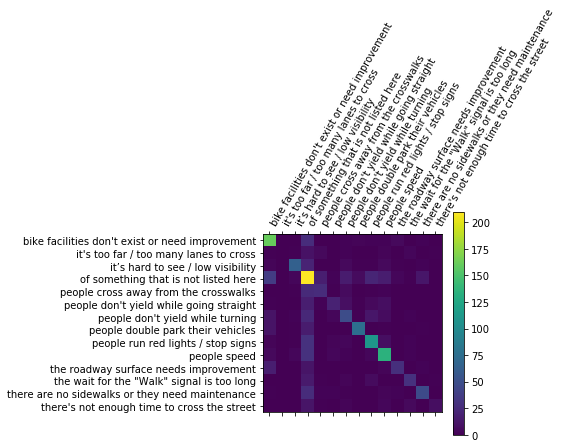

In [159]:
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

In [160]:
lr.score(X_test, y_test)

0.59814241486068109

In [161]:
from sklearn.metrics import f1_score
pred_test = lr.predict(X_test)
f1_score(y_test, pred_test, average="macro")

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1119: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.53705327135658576

In [162]:
feature_names = vect.get_feature_names()

In [163]:
lr.coef_.shape

(14, 5811)

In [164]:
def plot_important_features(coef, feature_names, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:10]
    high = inds[-10:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

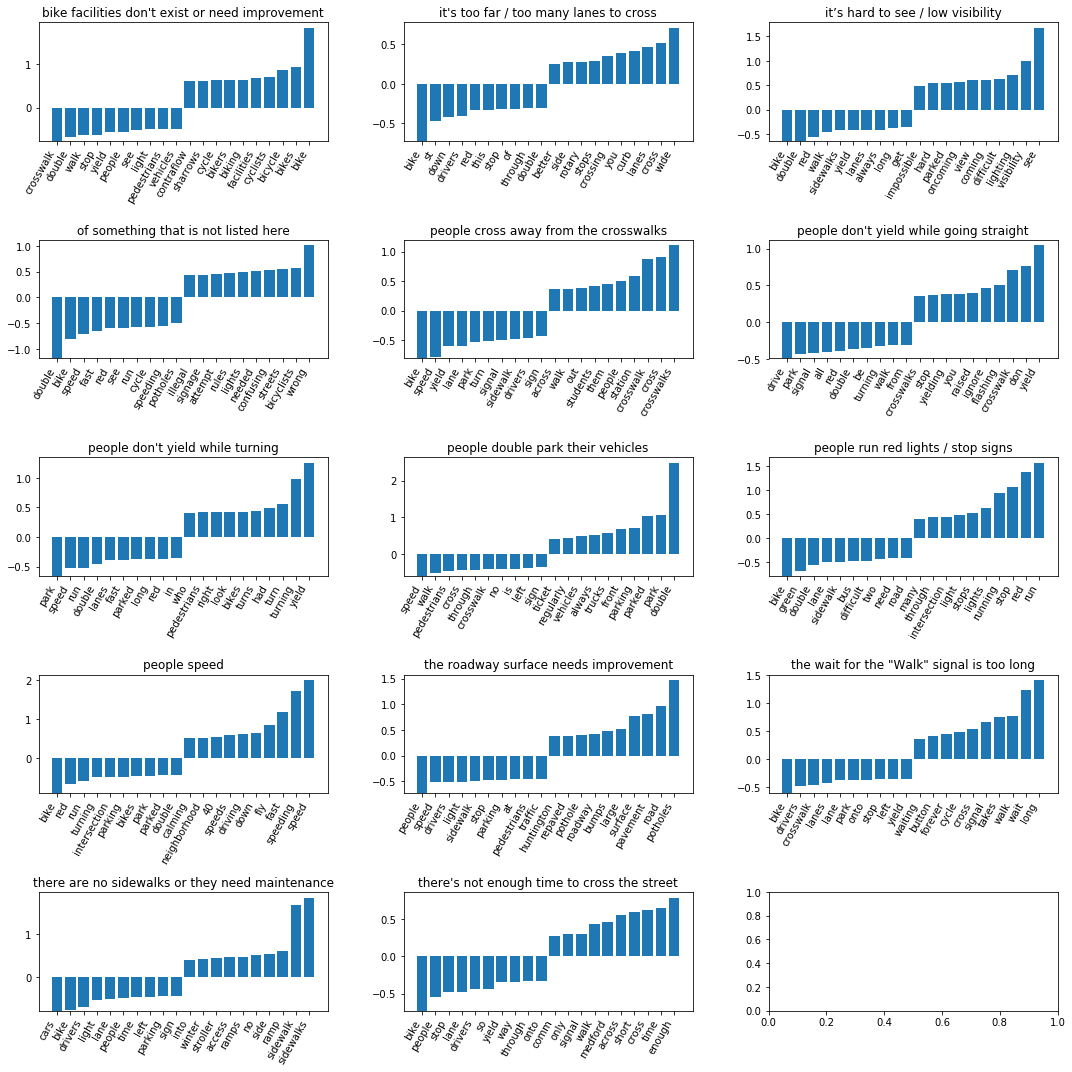

In [165]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

In [166]:
# better dedupe
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(X_train)

In [184]:
dists.argsort(axis=1)

array([[   0,  219, 1601, ..., 4213, 1650, 3881],
       [   1,  128,  121, ..., 1650, 1915, 3881],
       [   2, 4374, 4077, ..., 1915, 4213, 3881],
       ..., 
       [4842, 3594, 1073, ..., 1915, 4213, 3881],
       [4843, 4013, 1264, ..., 1650, 4213, 3881],
       [4844, 1244, 4447, ...,  328, 4213, 3881]])

In [199]:
closest = dists.argsort(axis=1)

In [200]:
closest

array([[   0,  219, 1601, ..., 4213, 1650, 3881],
       [   1,  128,  121, ..., 1650, 1915, 3881],
       [   2, 4374, 4077, ..., 1915, 4213, 3881],
       ..., 
       [4842, 3594, 1073, ..., 1915, 4213, 3881],
       [4843, 4013, 1264, ..., 1650, 4213, 3881],
       [4844, 1244, 4447, ...,  328, 4213, 3881]])

In [201]:
text_train.iloc[0]

'very deep, very large potholes'

In [202]:
text_train.iloc[219]

'Very dangerous'

In [204]:
np.argmin(dists[np.arange(dists.shape[0]), closest[:, 1]])

22

In [197]:
text_train.iloc[22]

'There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.'

In [205]:
text_train.iloc[closest[22, 1]]

'There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.'

In [206]:
text_train.iloc[closest[22, 2]]

'There is no streetlight with a walk light button to cross from the park to the Mass Pike towers.'

In [208]:
# which have close closest neighbors?
near_dupes = np.argsort(dists[np.arange(dists.shape[0]), closest[:, 1]])

In [216]:
dists[np.arange(dists.shape[0]), closest[:, 1]][near_dupes][20]

0.0

In [229]:
near_dupes[0]

2253

In [231]:
closest[near_dupes[0], 0]

1323

In [234]:
for i in range(40):
    print(text_train.iloc[near_dupes[i]])
    print(text_train.iloc[closest[near_dupes[i], 0]])
    print(text_train.iloc[closest[near_dupes[i], 1]])

This is a popular cut through street, where people speed on the straight away and it is not safe for kids. 30MPH is too fast for neighborhood streets, and many are faster than that.
This is a popular cut through street, where people speed on the straight away and it is not safe for kids.  30MPH is too fast for neighborhood streets, and many are faster than that.
This is a popular cut through street, where people speed on the straight away and it is not safe for kids. 30MPH is too fast for neighborhood streets, and many are faster than that.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about

In [228]:
df[df.COMMENTS.duplicated(keep=False)]

,REQUESTTYPE,COMMENTS
331,there are no sidewalks or they need maintenance,People park too close to the intersection and ...
333,it’s hard to see / low visibility,People park too close to the intersection and ...
4756,people don't yield while going straight,Drivers regularly barrel through this crosswal...
4757,people don't yield while turning,Drivers regularly barrel through this crosswal...
6278,people speed,There is no cross walk to connect the neighbor...
6279,people cross away from the crosswalks,There is no cross walk to connect the neighbor...
6944,people double park their vehicles,I commute by bike daily on Mass Ave from symph...
6945,bike facilities don't exist or need improvement,I commute by bike daily on Mass Ave from symph...
7098,it’s hard to see / low visibility,There's parking on both sides of this two-way ...
7099,of something that is not listed here,There's parking on both sides of this two-way ...


Could get duplicate mask of COMMENTS after stripping whitespace and punctuation - better deduplication!

# More Advanced Model
We should really do grid-search here.

In [237]:
char_ngram_pipe = make_pipeline(CountVectorizer(ngram_range=(1, 5), stop_words="english",
                                                analyzer="char_wb", lowercase=True, min_df=5),
                               LogisticRegression())


In [238]:
char_ngram_pipe.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 5), preprocessor=None, stop_words='engl...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [239]:
pred_test = char_ngram_pipe.predict(text_test)
pred_train = char_ngram_pipe.predict(text_train)

In [240]:
f1_score(y_test, pred_test, average="macro")

0.50693945440986465

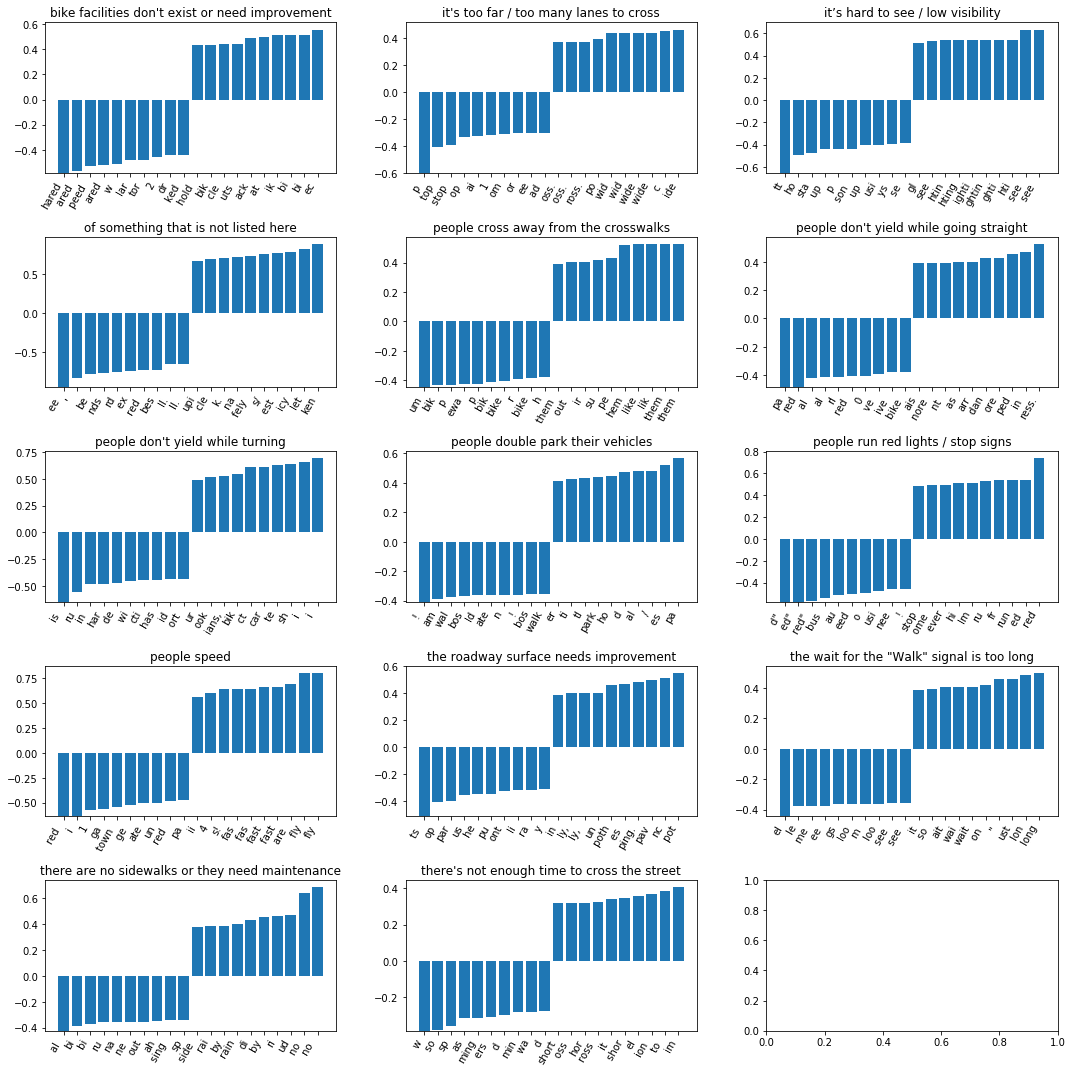

In [241]:
lr = char_ngram_pipe.named_steps['logisticregression']
n_classes = len(lr.classes_)
feature_names = char_ngram_pipe.named_steps['countvectorizer'].get_feature_names()
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

In [242]:
vect = CountVectorizer(ngram_range=(1, 2), min_df=4, stop_words='english')
X_train = vect.fit_transform(text_train)

In [243]:
len(vect.get_feature_names())

3545

In [244]:
lr = LogisticRegression().fit(X_train, y_train)

In [245]:
X_test = vect.transform(text_test)

In [246]:
lr.score(X_test, y_test)

0.58328173374613002

In [247]:
f1_score(y_test, lr.predict(X_test), average="macro")

0.53051926943165817

In [248]:
f1_score(y_train, lr.predict(X_train), average="macro")

0.93621591471587873

In [249]:
lr_balanced = LogisticRegression(C=.1, class_weight="balanced").fit(X_train, y_train)

In [250]:
f1_score(y_test, lr_balanced.predict(X_test), average="macro")

0.52708405376468126

In [251]:
f1_score(y_train, lr_balanced.predict(X_train), average="macro")

0.72086774183608926

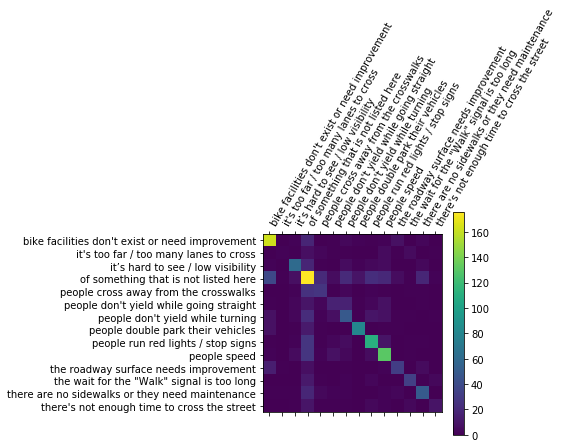

In [253]:
pred = lr.predict(X_test)
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

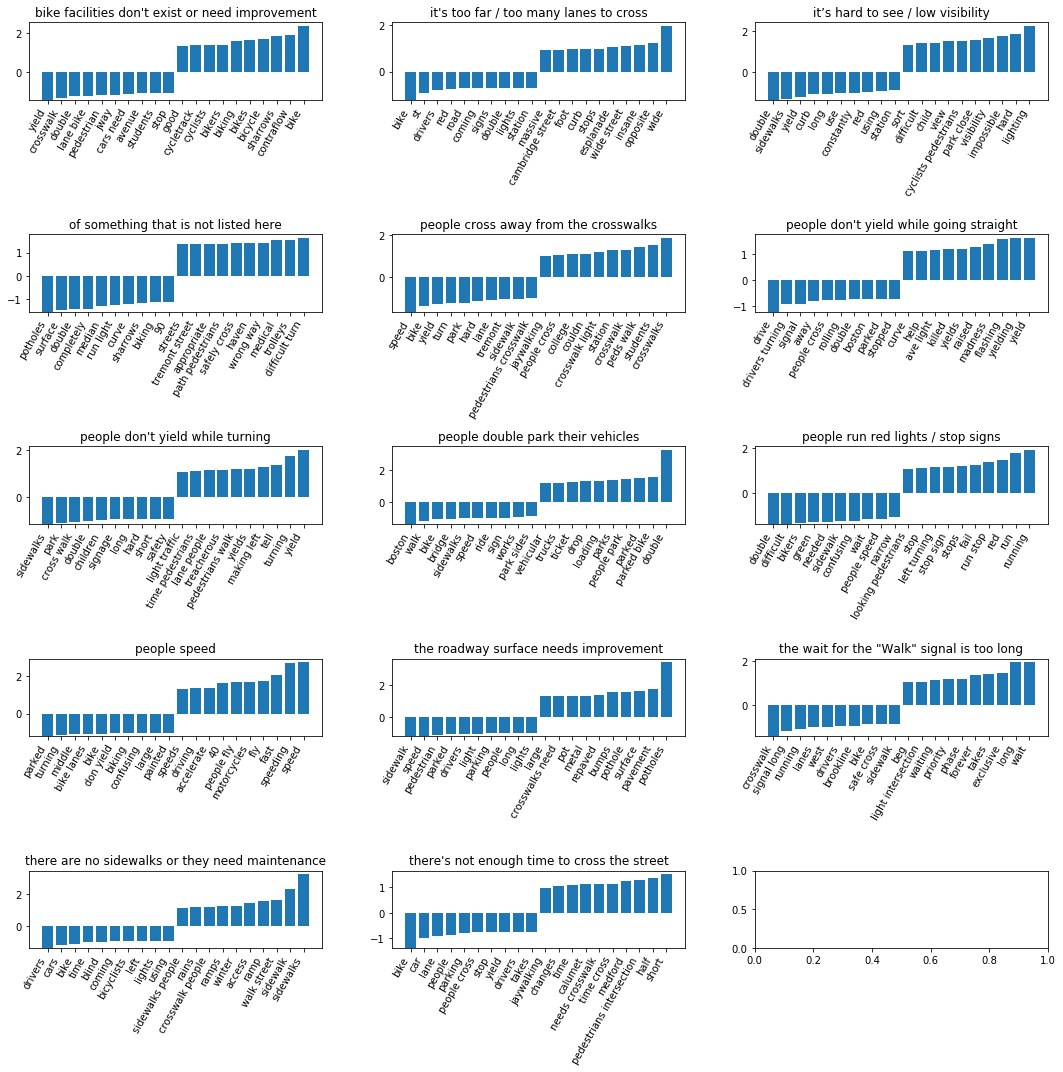

In [254]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

In [269]:
from sklearn.pipeline import make_union
combined_pipe = make_pipeline(make_union(CountVectorizer(ngram_range=(1, 2), min_df=4, stop_words='english'),
                                         CountVectorizer(ngram_range=(1, 5), stop_words="english", analyzer="char_wb",
                                                         lowercase=True, min_df=5)),
              LogisticRegression(C=.01, class_weight="balanced"))

In [270]:
combined_pipe.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('countvectorizer-1', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [271]:
f1_score(y_test, combined_pipe.predict(text_test), average="macro")

0.54595612850691766

In [272]:
f1_score(y_train, combined_pipe.predict(text_train), average="macro")

0.7826932155482843

# Clustering and Topic Modelling

In [202]:
len(df[df.COMMENTS.str.contains("wrong way")].COMMENTS.tolist())

76

In [203]:
inds, = np.where(df.COMMENTS.str.contains("wrong way") * df.REQUESTTYPE == "of something that is not listed here")

In [204]:
df = df.copy()

In [205]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'GLOBALID', 'REQUESTID', 'REQUESTTYPE',
       'REQUESTDATE', 'STATUS', 'STREETSEGID', 'COMMENTS', 'USERTYPE'],
      dtype='object')

In [206]:
df.iloc[inds, 5] = "wrong way"

In [214]:
requesttype = df["REQUESTTYPE"]
comments = df["COMMENTS"]
text_train, text_test, y_train, y_test = train_test_split(comments, requesttype, stratify=requesttype, random_state=0)
vect = CountVectorizer(ngram_range=(1, 2), min_df=2, stop_words="english")
X_train = vect.fit_transform(text_train)
X_test = vect.transform(text_test)

In [215]:
requesttype.value_counts()

of something that is not listed here               1353
bike facilities don't exist or need improvement     910
people speed                                        737
people run red lights / stop signs                  660
people don't yield while turning                    461
people double park their vehicles                   426
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     341
people don't yield while going straight             263
the roadway surface needs improvement               255
people cross away from the crosswalks               254
the wait for the "Walk" signal is too long          234
there's not enough time to cross the street         130
it's too far / too many lanes to cross              110
wrong way                                            65
Name: REQUESTTYPE, dtype: int64

In [216]:
lr = LogisticRegression(C=.1).fit(X_train, y_train)

In [217]:
lr.score(X_test, y_test)

0.57955232909860854

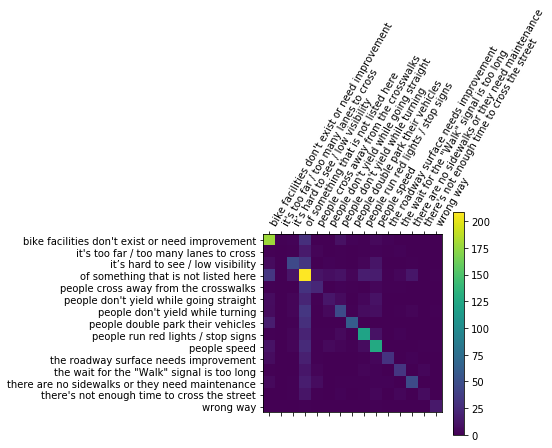

In [218]:
pred = lr.predict(X_test)
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

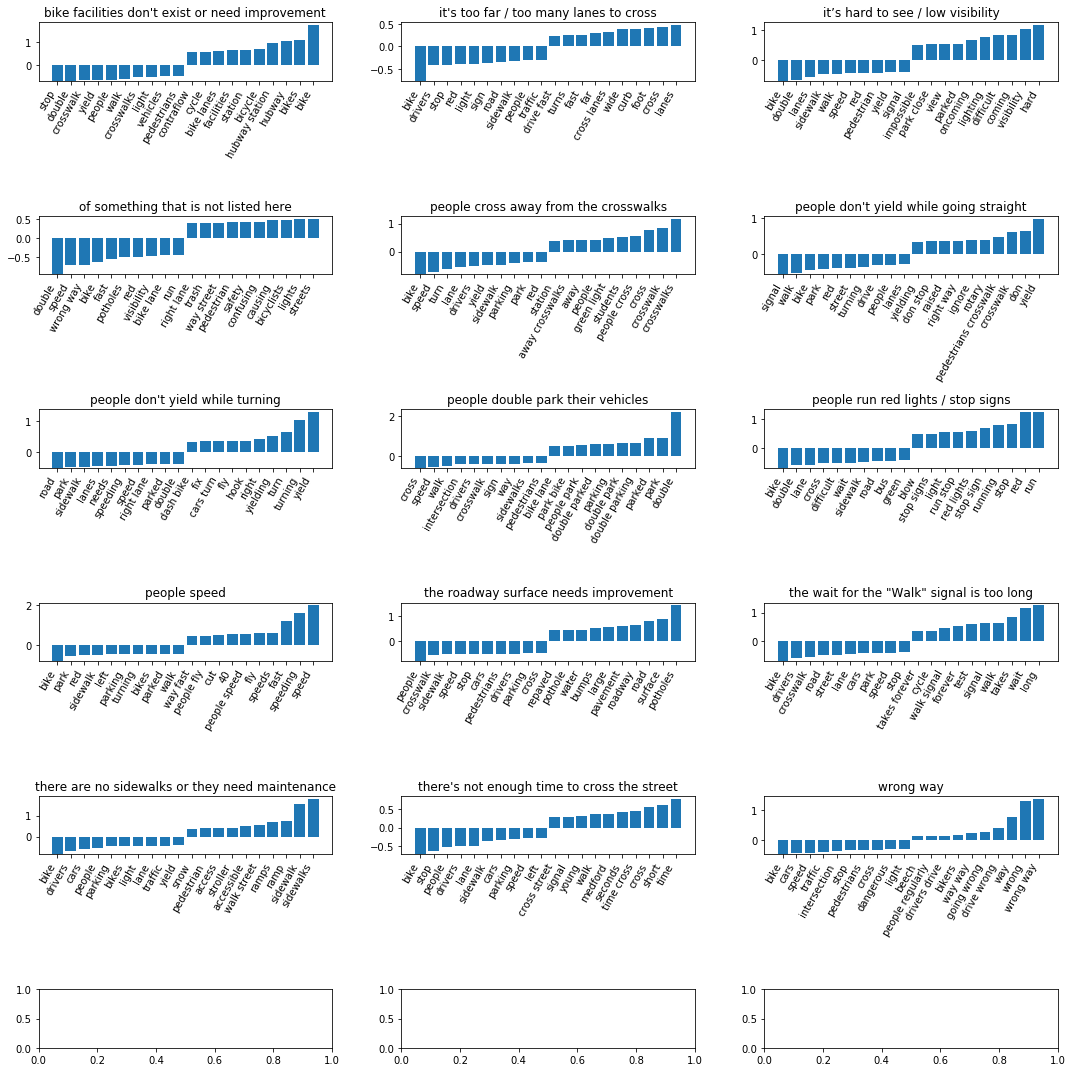

In [219]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

In [220]:
df[df.COMMENTS.str.contains("trash")].REQUESTTYPE.value_counts()

of something that is not listed here               11
there are no sidewalks or they need maintenance     6
people double park their vehicles                   3
people speed                                        1
wrong way                                           1
the roadway surface needs improvement               1
bike facilities don't exist or need improvement     1
Name: REQUESTTYPE, dtype: int64

In [299]:
"bike lane is in door zone", "bike lane used for driving / turning", "too narrow, should be one-way or restrict parking"

('bike lane is in door zone', 'bike lane used for driving / turning')

In [310]:
df[comments.str.contains("trolley")]

,REQUESTTYPE,COMMENTS
35,it's too far / too many lanes to cross,"An old woman tried to cross a parking lane, 2 ..."
1039,of something that is not listed here,There should be a stopsign so drivers stop for...
1115,of something that is not listed here,This intersection is a clusterfark for drivers...
1216,people don't yield while turning,People are always turning left and coming stra...
1619,it’s hard to see / low visibility,"The driveway for Mission Park is signalized, b..."
3547,of something that is not listed here,The MBTA trolleys consistently run the red lig...
4804,of something that is not listed here,Tour buses/trolleys frequently pull out into t...
5516,of something that is not listed here,There are drivers who do not yield to stopped ...
7152,people cross away from the crosswalks,People jaywalk across Comm Ave after exiting t...


In [312]:
df[comments.str.contains("lights")].REQUESTTYPE.value_counts()

people run red lights / stop signs                 125
of something that is not listed here                91
people speed                                        23
the wait for the "Walk" signal is too long          20
people don't yield while turning                    13
it’s hard to see / low visibility                   13
there's not enough time to cross the street         13
people don't yield while going straight              9
people cross away from the crosswalks                8
people double park their vehicles                    7
bike facilities don't exist or need improvement      6
there are no sidewalks or they need maintenance      4
the roadway surface needs improvement                2
it's too far / too many lanes to cross               1
Name: REQUESTTYPE, dtype: int64

In [314]:
df[comments.str.contains("way street")].REQUESTTYPE.value_counts()

of something that is not listed here               49
people speed                                       18
bike facilities don't exist or need improvement     7
it’s hard to see / low visibility                   7
people double park their vehicles                   5
people don't yield while turning                    2
people don't yield while going straight             2
people run red lights / stop signs                  2
the wait for the "Walk" signal is too long          1
there are no sidewalks or they need maintenance     1
the roadway surface needs improvement               1
Name: REQUESTTYPE, dtype: int64

In [318]:
list(df[comments.str.contains("way street")].COMMENTS)

of something that is not listed here               49
people speed                                       18
bike facilities don't exist or need improvement     7
it’s hard to see / low visibility                   7
people double park their vehicles                   5
people don't yield while turning                    2
people don't yield while going straight             2
people run red lights / stop signs                  2
the wait for the "Walk" signal is too long          1
there are no sidewalks or they need maintenance     1
the roadway surface needs improvement               1
Name: REQUESTTYPE, dtype: int64

In [319]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1402
bike facilities don't exist or need improvement     817
people speed                                        742
people run red lights / stop signs                  650
people don't yield while turning                    452
people double park their vehicles                   423
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     339
people don't yield while going straight             256
people cross away from the crosswalks               254
the roadway surface needs improvement               250
the wait for the "Walk" signal is too long          226
there's not enough time to cross the street         131
it's too far / too many lanes to cross              106
Name: REQUESTTYPE, dtype: int64